---
author: Zeel B Patel
badges: true
categories: ML
description: Challenges in using GNNs for regression using various strategies
title: Graph Neural Networks for Regression
date: '2023-06-12'
toc: true
---

In [76]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import GPy

import torch
import torch.nn as nn

from tqdm import trange

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

device = "cuda"

## Create a synthetic dataset

torch.Size([50, 1]) torch.Size([50, 1]) torch.Size([50, 1])


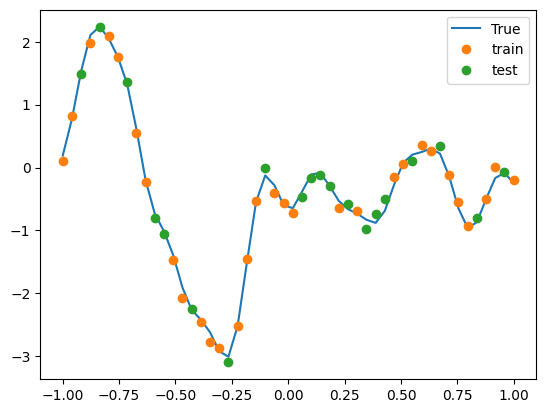

In [77]:
np.random.seed(0)
torch.random.manual_seed(4)

N = 50
x = np.linspace(-1, 1, N).reshape(-1, 1)
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.1)
y = np.random.multivariate_normal(np.zeros(N), kernel.K(x)).reshape(-1, 1)
y_noisy = y + np.random.normal(0, 0.1, N).reshape(-1, 1)

train_x, test_x, train_y, test_y = train_test_split(x, y_noisy, test_size=0.4, random_state=0)

plt.plot(x, y, label="True");
plt.plot(train_x, train_y, 'o', label='train')
plt.plot(test_x, test_y, 'o', label='test')
plt.legend();

x, y, y_noisy = map(lambda x: torch.tensor(x).float().to(device), (x, y, y_noisy))
train_x, test_x, train_y, test_y = map(lambda x: torch.tensor(x).float().to(device), (train_x, test_x, train_y, test_y))
print(x.shape, y.shape, y_noisy.shape)

## Fit with a simple MLP

In [78]:
def fit(model, x, y, A=None, lr=0.01, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    
    if A is None:
        inputs = (x,)
    else:
        inputs = (x, A)
    
    losses = []
    pbar = trange(epochs)
    for epoch in pbar:
        optimizer.zero_grad()
        y_hat = model(*inputs)
        loss = loss_fn(y_hat, y)
        losses.append(loss.item())
        pbar.set_description(f"Epoch {epoch} Loss: {loss.item()}")
        loss.backward()
        optimizer.step()
            
    return losses

class SimpleMLP(nn.Module):
    def __init__(self, features):
        super().__init__()
        layers = [nn.Linear(1, features[0]), nn.ReLU()]
        for in_features, out_features in zip(features, features[1:]):
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            
        layers.append(nn.Linear(features[-1], 1))
        
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.layers(x)

Epoch 999 Loss: 0.07143261283636093: 100%|██████████| 1000/1000 [00:02<00:00, 448.34it/s]


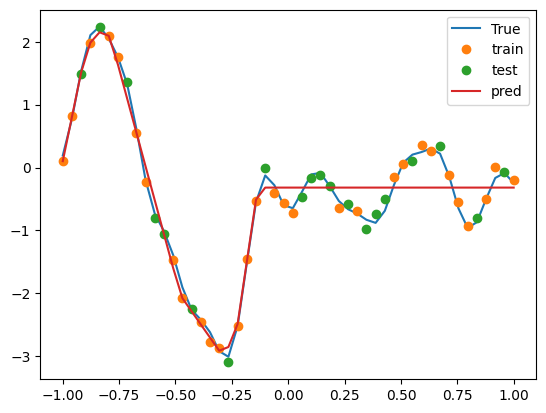

In [79]:
torch.manual_seed(0)
model = SimpleMLP([10, 10, 10]).to(device)
fit(model, train_x, train_y, lr=0.01, epochs=1000);

pred_y = model(x)

(x_, y_, train_x_, train_y_, test_x_, test_y_, pred_y_) = map(lambda x: x.cpu().detach().numpy(), (x, y, train_x, train_y, test_x, test_y, pred_y))
plt.plot(x_, y_, label="True");
plt.plot(train_x_, train_y_, 'o', label='train')
plt.plot(test_x_, test_y_, 'o', label='test')
plt.plot(x_, pred_y_, label='pred')
plt.legend();

## Create a GCN layer

In [80]:
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x, A):    
        return self.linear(A @ x)
    
    
class GCN(nn.Module):
    def __init__(self, features):
        super().__init__()
        layers = [GCNLayer(1, features[0]), nn.ReLU()]
        for in_features, out_features in zip(features, features[1:]):
            layers.append(GCNLayer(in_features, out_features))
            layers.append(nn.ReLU())
            
        layers.append(GCNLayer(features[-1], 1))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x, A):
        for layer in self.layers:
            if isinstance(layer, GCNLayer):
                x = layer(x, A)
            else:
                x = layer(x)
        return x
    
def get_eucledean_A(x, exponent):
    d = ((x - x.T)**2)**0.5
    d = torch.where(d==0, torch.min(d[d!=0])/2, d)  # self distance is 0, so replace it with half of the min distance
    A = 1/(d**exponent)
    return A/A.sum(dim=1, keepdim=True)

def get_KNN_A(x, k):
    d = torch.abs(x - x.T)
    A = torch.zeros_like(d)
    _, indices = torch.topk(d, k, dim=1, largest=False)
    for i, index in enumerate(indices):
        A[i, index] = 1
    return A/A.sum(dim=1, keepdim=True)

def fit_and_plot(title):
    model = GCN([10, 10, 10]).to(device)
    losses = fit(model, train_x, train_y, A=A_train, lr=0.001, epochs=3000);

    pred_y = model(x, A_all)

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    axes = ax[0]
    axes.plot(losses)
    axes.set_title("Losses")

    (x_, y_, train_x_, train_y_, test_x_, test_y_, pred_y_) = map(lambda x: x.cpu().detach().numpy(), (x, y, train_x, train_y, test_x, test_y, pred_y))
    axes = ax[1]
    axes.plot(x_, y_, label="True");
    axes.plot(train_x_, train_y_, 'o', label='train')
    axes.plot(test_x_, test_y_, 'o', label='test')
    axes.plot(x_, pred_y_, label='pred')
    axes.set_title(title)
    axes.legend();

## IDW setting

Epoch 2999 Loss: 0.07731884717941284: 100%|██████████| 3000/3000 [00:07<00:00, 401.90it/s]


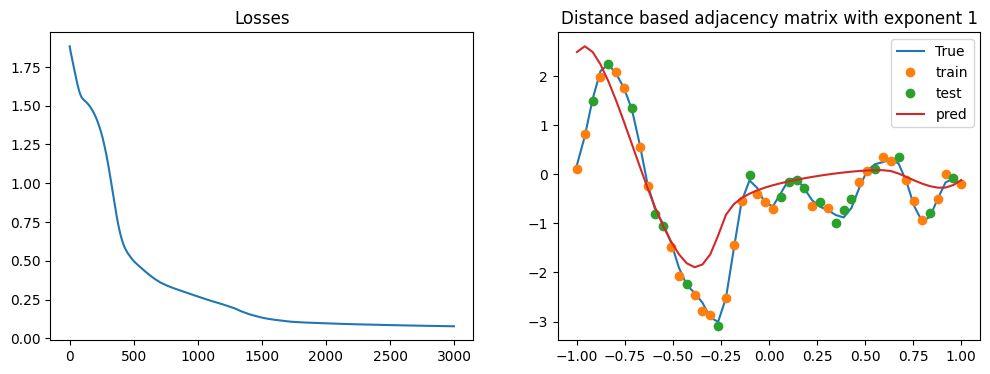

In [81]:
exponent = 1
A_train = get_eucledean_A(train_x, exponent).to(device)
A_all = get_eucledean_A(x, exponent).to(device)
title = f"Distance based adjacency matrix with exponent {exponent}"

fit_and_plot(title)

Epoch 2999 Loss: 0.0778026208281517: 100%|██████████| 3000/3000 [00:07<00:00, 386.31it/s] 


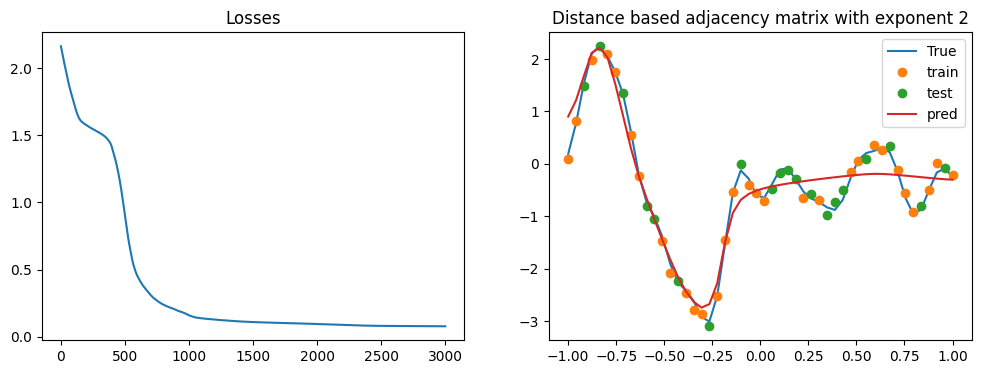

In [82]:
exponent = 2
A_train = get_eucledean_A(train_x, exponent).to(device)
A_all = get_eucledean_A(x, exponent).to(device)
title = f"Distance based adjacency matrix with exponent {exponent}"

fit_and_plot(title)

Epoch 2999 Loss: 0.04420239478349686: 100%|██████████| 3000/3000 [00:08<00:00, 369.61it/s] 


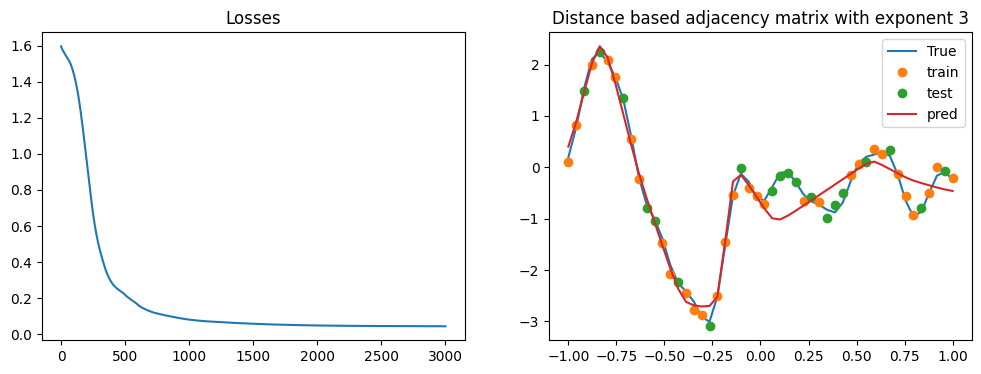

In [83]:
exponent = 3
A_train = get_eucledean_A(train_x, exponent).to(device)
A_all = get_eucledean_A(x, exponent).to(device)
title = f"Distance based adjacency matrix with exponent {exponent}"

fit_and_plot(title)

## KNN Setting

Epoch 2999 Loss: 0.04107221961021423: 100%|██████████| 3000/3000 [00:08<00:00, 374.39it/s] 


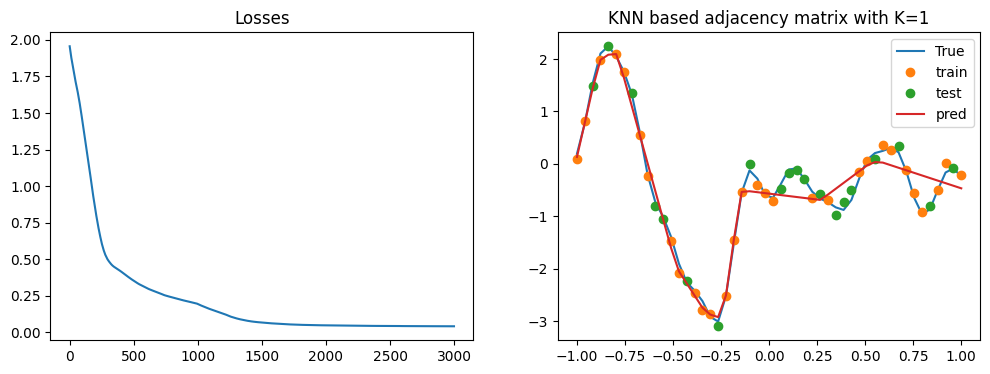

In [84]:
K = 1
A_train = get_KNN_A(train_x, K).to(device)
A_all = get_KNN_A(x, K).to(device)
title = f"KNN based adjacency matrix with K={K}"

fit_and_plot(title)

Epoch 2999 Loss: 0.15448586642742157: 100%|██████████| 3000/3000 [00:07<00:00, 386.62it/s]


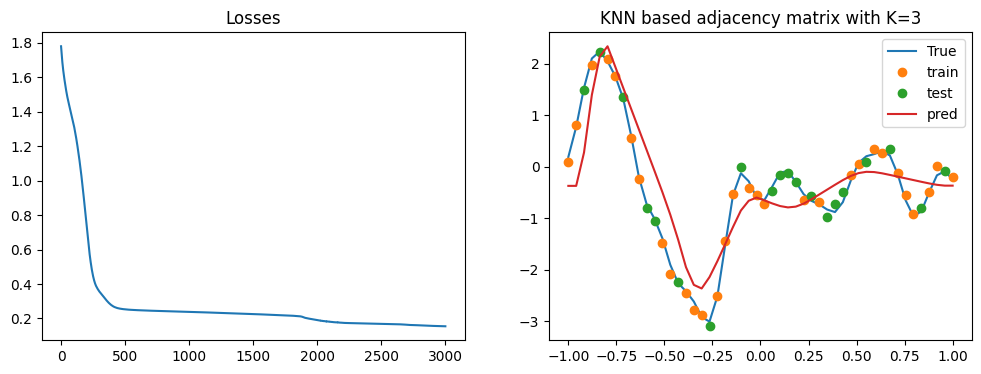

In [85]:
K = 3
A_train = get_KNN_A(train_x, K).to(device)
A_all = get_KNN_A(x, K).to(device)
title = f"KNN based adjacency matrix with K={K}"

fit_and_plot(title)

Epoch 2999 Loss: 0.18613268435001373: 100%|██████████| 3000/3000 [00:08<00:00, 374.51it/s]


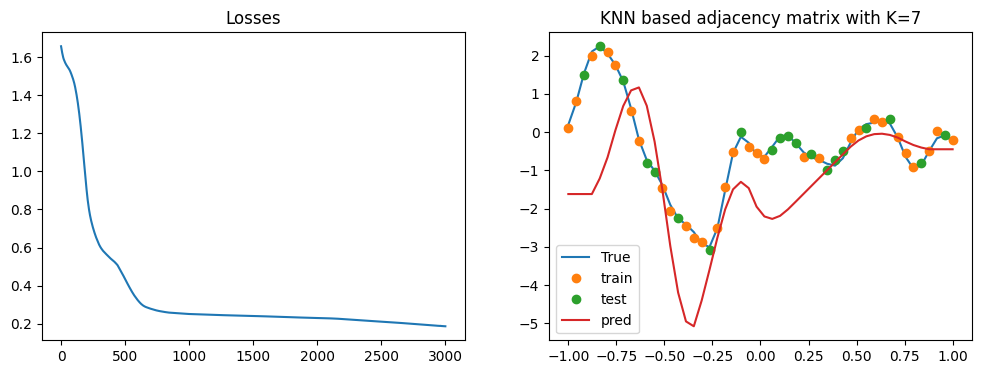

In [86]:
K = 7
A_train = get_KNN_A(train_x, K).to(device)
A_all = get_KNN_A(x, K).to(device)
title = f"KNN based adjacency matrix with K={K}"

fit_and_plot(title)

Epoch 2999 Loss: 0.797140896320343: 100%|██████████| 3000/3000 [00:07<00:00, 377.66it/s] 


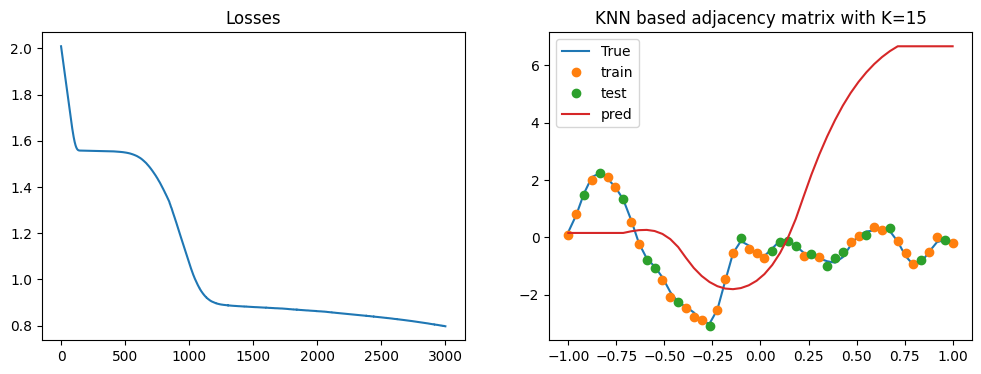

In [87]:
K = 15
A_train = get_KNN_A(train_x, K).to(device)
A_all = get_KNN_A(x, K).to(device)
title = f"KNN based adjacency matrix with K={K}"

fit_and_plot(title)